Evaluating Reviewer Randomness
===========================

I have often heard the suggestion that the randomness associated with reviews can be reduced if we accept more papers. My intuition is that this is not the case, and shifting the target number of papers only shifts the papers for which there is randomness.

Model
--

Here's a simple model to back up my intuition. The goal here is to identify the top _k_% of papers. In this model, each paper has a "true rank" from 0% to 100%. Each reviewerer assigns a score to the paper reflecting their subjective rank, which is normally distributed around the true rank with some standard deviation. The decision rule is simple: if the average of the reviewers' rankings is over the threshold, tryng to roughly capture a "consensus" decision.

Based on this, for any rank of the paper we can determine the probability whether it is accepted or not.

In [1]:
from scipy.stats import norm
from math import sqrt, log
from numpy import linspace

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt

In [9]:
def accept_probabilities(threshold, nreviews=3, stdev=0.2, npoints=100):
    """ average stdev of based on computing the average of nreviews """
    stdavg = stdev/sqrt(nreviews)
    
    return [1-norm.cdf(threshold, i/npoints, stdavg) for i in range(npoints+1)]
    

def accept_plot(threshold, nreviews=3, stdev=0.2, npoints=100, **kwargs):
    """ 
    plot the probability that a paper with actual rank x will be accepted, given that:
    - each review score is normally distributed around the actual rank
    - a paper is accepted if it's average score is greater than threshold
    """
    
    x = linspace(0,1,npoints+1)
    y = accept_probabilities(threshold, nreviews, stdev, npoints)
    plt.plot(x,y, **kwargs)
    plt.axvline(threshold, color='r', linestyle='--')
    plt.xlabel("Paper rank")
    plt.ylabel("Chance of acceptance")
    plt.title(f"Threshold {threshold*100:.0f}%, {nreviews} reviews with stdev {stdev*100:.0f}%\n")

Let us try a few values. First, let us see a non-random version, where the reviewers always identify the true rank of the paper:

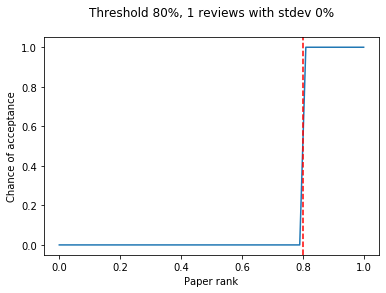

In [10]:
accept_plot(0.8, nreviews=1, stdev=1e-08)
# normal distribution doesn't work with stdev 0

A nice sharp threshold, all papers above the threshold are accepted, all papers below are rejected.

Next let us look at more typical values. I set the standard deviation at 20%, and use 3 reviewers in the average. We will make our conference moderately competitive, with 20% of the papers being accepted

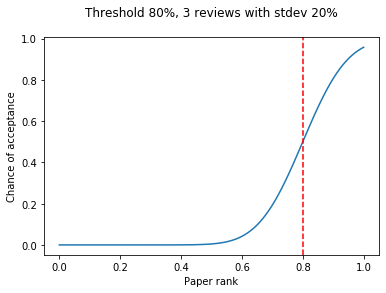

In [11]:
accept_plot(0.8, nreviews=3, stdev=0.2)

A lot of randomness! And a reasonable match for my experience: about half the papers are clear rejects, a small fraction of papers (around 5%) are clear accepts, and but a big chunk of papers is in the middle, where their acceptance is basically a coin toss. Now let us adjust the acceptance threshold:

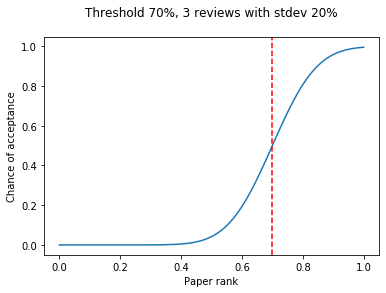

In [12]:
accept_plot(0.7, nreviews=3, stdev=0.2)

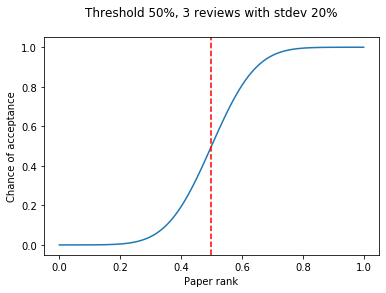

In [13]:
accept_plot(0.5, nreviews=3, stdev=0.2)

We can now see that there is a larger fraction of papers that are definitely accepted. At the same time, there is a new uncertainty region that has been shited down to the lower ranked papers. 

How do we evaluate the amount of uncertainty? One simple way is to compute the entropy of the probability distribution for each rank. Then we can average the entropy across all papers. (I'm going to compute the average numerically; if there's a simple closed form approach, let me know!)

In [14]:
def review_uncertainty(threshold, nreviews=3, stdev=0.2, npoints=100):
    y = accept_probabilities(threshold, nreviews, stdev, npoints)
    # compute the entropy of each rank: H(p) = - p log p - (1-p) log (1-p)
    ave_entropy = -sum(p * log(p,2) + (1-p) * log(1-p,2) for p in y if 0 < p < 1) / (npoints+1)
    return ave_entropy

In [15]:
review_uncertainty(0.8, 1, 1e-08) # this would be 0 if we could set stdev to 0

0.009900990099009901

In [16]:
review_uncertainty(0.8, 3, 0.2)

0.28504940057098105

In [17]:
review_uncertainty(0.7, 3, 0.2)

0.29637953019774366

In [18]:
review_uncertainty(0.5, 3, 0.2)

0.2979384850943906

In [19]:
review_uncertainty(0.9, 3, 0.2)

0.241155385201404

So we can see that, shifting the threshold down actually _increases_ uncertainty, though not by much. Only making the conference very competitive, with only 10% of papers accepted, results in significantly less uncertainty. 

Note: you can argue that the 30% or 50% acceptance rate is better because there is more of a certainty region that is spread among the "good" papers: with 50%, about the top 20% of the papers have a pretty clear disposition, whereas with an 80% acceptance rate only perhaps the top 5%. Perhaps we can think about this by computing the rate of "false positives" and "false negatives", i.e., the chance of accepting a paper below the threshold and rejecting a peper above the threshold?

In [20]:
def error_rates(threshold, nreviews=3, stdev=0.2, npoints=100):
    y = accept_probabilities(threshold, nreviews, stdev, npoints)

    fps = [p for i,p in enumerate(y) if i/npoints < threshold]
    fp_rate = sum(fps) / len(fps)
    # note that we skip the probability of paper = threshold just to avoid boundary conditions
    fns = [1-p for i,p in enumerate(y) if i/npoints > threshold] 
    fn_rate = sum(fns) / len(fns)
    return fp_rate, fn_rate

In [21]:
for threshold in [0.5, 0.7, 0.8, 0.9]:
    print(f"Threshold: {threshold*100:.1f}. ", end='')
    fp, fn = error_rates(threshold, 3, 0.2)
    print(f"False positive rate: {fp*100:.1f}%, false negative rate: {fn*100:.1f}%")



Threshold: 50.0. False positive rate: 8.7%, false negative rate: 8.7%
Threshold: 70.0. False positive rate: 6.2%, false negative rate: 14.5%
Threshold: 80.0. False positive rate: 5.4%, false negative rate: 20.9%
Threshold: 90.0. False positive rate: 4.8%, false negative rate: 32.2%


Definitely matches our observation above: competitive conferences make it much more likely that a paper will be rejected if it's over threshold. Less competitive conferences, on the other hand, have a higher chance of accepting under threshold papers, even though the threshold itself is lower.

Another metric we can compute is, how much of the program is expected to be over the threshold?

In [22]:
def over_threshold(threshold, nreviews=3, stdev=0.2, npoints=100):
    fp_rate, fn_rate = error_rates(threshold, nreviews, stdev, npoints)
    # accepted over threshold papers. THe base rate is 1-threshold, and fn of these will get rejected
    accept_over_thresh = (1-threshold) * (1-fn_rate)
    # accepted under threshold papers. THe base rate is threshold, and p of these will get rejected
    accept_under_thresh = threshold * fp_rate
    return accept_over_thresh / (accept_over_thresh + accept_under_thresh)

    

In [23]:
for threshold in [0.5, 0.7, 0.8, 0.9]:
    result = over_threshold(threshold, 3, 0.2)
    print(f"Threshold: {threshold*100:.1f}, {result*100:.0f}% of accepted papers over threshold")

Threshold: 50.0, 91% of accepted papers over threshold
Threshold: 70.0, 85% of accepted papers over threshold
Threshold: 80.0, 78% of accepted papers over threshold
Threshold: 90.0, 61% of accepted papers over threshold


So a super competitive conference not only rejects roughly a third of over threshold papers, the program also ends up with a third of the papers being below the threshold. 

Of course, it makes a difference just how far below the threshold these are

In [24]:
def accepted_above_threshold(t2, threshold, nreviews=3, stdev=0.2, npoints=100):
    """ number of accepted papers that are above threshold t2 in the rank """
    y = accept_probabilities(threshold, nreviews, stdev, npoints)

    below = sum(p for i,p in enumerate(y) if i/npoints < t2)
    above = sum(p for i,p in enumerate(y) if i/npoints > t2)
    
    return above/(above+below)

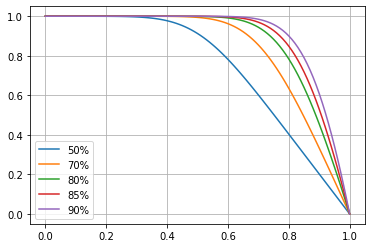

In [25]:
x = [i/100 for i in range(0, 101)]
for threshold in [0.5, 0.7, 0.8, 0.85, 0.9]:
    plt.plot(x, [accepted_above_threshold(t2, threshold, 3, 0.2) for t2 in x], label=f"{threshold*100:.0f}%")
plt.legend()
plt.grid()
pass

So we can see, for example, that with a 10% acceptance rate a bit more than 80% of the accepted papers are in the top 5th of the submissions. But with a 20% acceptance rate, that number is a bit fewer than 80%. Overall, the quality of the program does not seem to shift all that much between 10 and 20% acceptance rates.

What can reduce randomness? Certainly changing the effective standard deviation will help, which we can do by changing the number of reviewers.

2 reviewers; entropy: 0.34, FP: 6.7%, FN: 24.7%, over threshold: 73.6%
3 reviewers; entropy: 0.29, FP: 5.4%, FN: 20.9%, over threshold: 78.4%
4 reviewers; entropy: 0.25, FP: 4.7%, FN: 18.3%, over threshold: 81.4%
5 reviewers; entropy: 0.23, FP: 4.2%, FN: 16.4%, over threshold: 83.4%


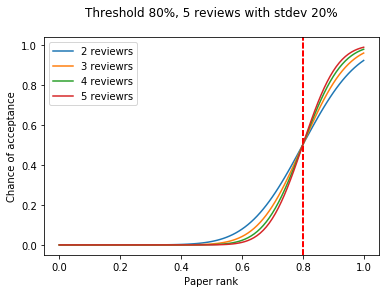

In [26]:
for nreviewers in range(2,6):
    accept_plot(0.8, nreviewers, 0.2, label=f"{nreviewers} reviewrs")
    ent = review_uncertainty(0.8, nreviewers, 0.2)
    fp, fn = error_rates(0.8, nreviewers, 0.2)
    overt = over_threshold(0.8, nreviewers, 0.2)
    print(f"{nreviewers} reviewers; entropy: {ent:.2f}, FP: {fp * 100:.1f}%, FN: {fn * 100:.1f}%, over threshold: {overt*100:.1f}%")
plt.legend()
pass

But be careful! If you have extra reviewers who write more random reviews, this may not help!

In [27]:
from numpy import linspace

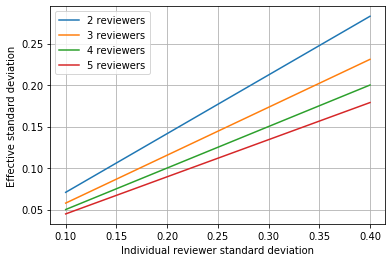

In [28]:
for nreviewers in range(2,6):
    x = linspace(0.1, 0.4, 100)
    plt.plot(x, [s/sqrt(nreviewers) for s in x], label=f"{nreviewers} reviewers")
plt.xlabel("Individual reviewer standard deviation")
plt.ylabel("Effective standard deviation")
plt.grid()
plt.legend()
pass

Note in particular that 3 reviewers with 20% SD actually have slightly less randomness than 4 reviewers with 25% SD. (Perhaps adding some expertise weighting to the model might get us better results)